# Emojify! // By: Ehab Osama

# Introduction

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. 
So rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍 Let's get coffee and talk. ☕️ Love you! ❤️"

* You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

#### Using word vectors to improve emoji lookups
* In many emoji interfaces, you need to remember that ❤️ is the "heart" symbol rather than the "love" symbol. 
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.

#### Aims of the project:
1. I'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then I will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

# Importing

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### 1.1 - Dataset EMOJISET

I have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

Let's load the dataset using the code below. We split the dataset between training (127 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

In [4]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞

I am proud of your achievements 😄

It is the worst day in my life 😞

Miss you so much ❤️

food is life 🍴

I love you mum ❤️

Stop saying bullshit 😞

congratulations on your acceptance 😄

The assignment is too long  😞

I want to go play ⚾


### 1.2 - Overview of the Emojifier-V1

#### Inputs and outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you). 
* The output will be a probability vector of shape (1,5), (there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot encoding
* To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Let's see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values. 

In [6]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️

Label index 0 in one-hot encoding format is [ 1.  0.  0.  0.  0.]


All the data is now ready to be fed into the Emojify-V1 model. Let's implement the model!

### 1.3 - Implementing Emojifier-V1

* Convert each word in the input sentence into their word vector representations.
* Then take an average of the word vectors. 
* Similar to the previous exercise, we will use pre-trained 50-dimensional GloVe embeddings. 


In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../../readonly/glove.6B.50d.txt')

I've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.


In [8]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317

the 289846th word in the vocabulary is potatos


In [9]:
#FUNCTION: sentence_to_avg

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
   
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
   
    return avg

In [10]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

avg = 

 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983

 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867

  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767

  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061

  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265

  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925

 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333

 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433

  0.1445417   0.09808667]


# Building the Model!

In [11]:
#model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
           
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i] * np.log(a))
        
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5,0,0,5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is suprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)

(132,)

(132, 5)

never talk to me again

<class 'numpy.ndarray'>

(20,)

(20,)

(132, 5)

<class 'numpy.ndarray'>


In [13]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.95204988128

Accuracy: 0.348484848485

Epoch: 100 --- cost = 0.0797181872601

Accuracy: 0.931818181818

Epoch: 200 --- cost = 0.0445636924368

Accuracy: 0.954545454545

Epoch: 300 --- cost = 0.0343226737879

Accuracy: 0.969696969697

[[ 3.]

 [ 2.]

 [ 3.]

 [ 0.]

 [ 4.]

 [ 0.]

 [ 3.]

 [ 2.]

 [ 3.]

 [ 1.]

 [ 3.]

 [ 3.]

 [ 1.]

 [ 3.]

 [ 2.]

 [ 3.]

 [ 2.]

 [ 3.]

 [ 1.]

 [ 2.]

 [ 3.]

 [ 0.]

 [ 2.]

 [ 2.]

 [ 2.]

 [ 1.]

 [ 4.]

 [ 3.]

 [ 3.]

 [ 4.]

 [ 0.]

 [ 3.]

 [ 4.]

 [ 2.]

 [ 0.]

 [ 3.]

 [ 2.]

 [ 2.]

 [ 3.]

 [ 4.]

 [ 2.]

 [ 2.]

 [ 0.]

 [ 2.]

 [ 3.]

 [ 0.]

 [ 3.]

 [ 2.]

 [ 4.]

 [ 3.]

 [ 0.]

 [ 3.]

 [ 3.]

 [ 3.]

 [ 4.]

 [ 2.]

 [ 1.]

 [ 1.]

 [ 1.]

 [ 2.]

 [ 3.]

 [ 1.]

 [ 0.]

 [ 0.]

 [ 0.]

 [ 3.]

 [ 4.]

 [ 4.]

 [ 2.]

 [ 2.]

 [ 1.]

 [ 2.]

 [ 0.]

 [ 3.]

 [ 2.]

 [ 2.]

 [ 0.]

 [ 3.]

 [ 3.]

 [ 1.]

 [ 2.]

 [ 1.]

 [ 2.]

 [ 2.]

 [ 4.]

 [ 3.]

 [ 3.]

 [ 2.]

 [ 4.]

 [ 0.]

 [ 0.]

 [ 3.]

 [ 3.]



The model has pretty high accuracy on the training set. Lets now see how it does on the test set. 

### 1.4 - Examining test set performance 

The `predict` function used here is defined in emo_util.spy.

In [14]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:

Accuracy: 0.977272727273

Test set:

Accuracy: 0.857142857143


* Random guessing would have had 20% accuracy given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples. 


#### The model matches emojis to relevant words
In the training set, the algorithm saw the sentence 
>"*I love you*" 

with the label ❤️. 
* I can check that the word "adore" does not appear in the training set. 
* Nonetheless, lets see what happens if I write "*I adore you*."



In [15]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.833333333333



i adore you ❤️

i love you ❤️

funny lol 😄

lets play with a ball ⚾

food is ready 🍴

not feeling happy 😄




#### Word ordering isn't considered in this model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)

           ❤️    ⚾    😄    😞   🍴

Predicted  0.0  1.0  2.0  3.0  4.0  All

Actual                                 

0            6    0    0    1    0    7

1            0    8    0    0    0    8

2            2    0   16    0    0   18

3            1    1    2   12    0   16

4            0    0    1    0    6    7

All          9    9   19   13    6   56


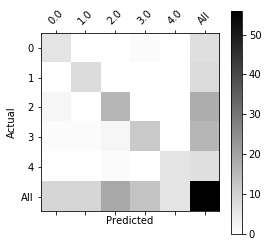

In [16]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

    
**I will build a better algorithm in the next section!**

## 2 - Emojifier-V2: Using LSTMs in Keras: 

Let's build an LSTM model that takes word **sequences** as input!
* This model will be able to account for the word ordering. 
* Emojifier-V2 will continue to use pre-trained word embeddings to represent words.
* We will feed word embeddings into an LSTM.
* The LSTM will learn to predict the most appropriate emoji. 


In [17]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### 2.1 Keras and mini-batching 

* Now, I want to train Keras using mini-batches. 
* However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 
    * This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding handles sequences of varying length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 


#### Inputs and outputs to the embedding layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 



In [18]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx,val)

0 I

1 like

2 learning


In [19]:
#FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
            
   
    
    return X_indices

In [20]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']

X1_indices =

 [[ 155345.  225122.       0.       0.       0.]

 [ 220930.  286375.   69714.       0.       0.]

 [ 151204.  192973.  302254.  151349.  394475.]]


#### Building embedding layer

* Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. 
* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence.  

In [21]:
# FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [22]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## 2.3 Building the Emojifier-V2

Lets now build the Emojifier-V2 model. 
* By feed the embedding layer's output to an LSTM network. 


In [23]:
#FUNCTION: Emojify_V2

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
   
    # Define sentence_indices as the input of the graph
    # It should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)    
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
   
    
    return model

The following cell creates the model and check its summary. 

Because all sentences in the dataset are less than 10 words, I chose `max_len = 10`. 

In [24]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         (None, 10)                0         

_________________________________________________________________

embedding_2 (Embedding)      (None, 10, 50)            20000050  

_________________________________________________________________

lstm_1 (LSTM)                (None, 10, 128)           91648     

_________________________________________________________________

dropout_1 (Dropout)          (None, 10, 128)           0         

_________________________________________________________________

lstm_2 (LSTM)                (None, 128)               131584    

_________________________________________________________________

dropout_2 (Dropout)          (None, 128)               0         

_________________________________________________________________

dense_1 (Dense)              (None, 5)                 645   

As usual, after creating model in Keras, I need to compile it and define what loss, optimizer and metrics I want to use.

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [27]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50

132/132 [==============================] - 0s - loss: 1.6105 - acc: 0.1667     

Epoch 2/50

132/132 [==============================] - 0s - loss: 1.5378 - acc: 0.3106     

Epoch 3/50

132/132 [==============================] - 0s - loss: 1.5061 - acc: 0.3030     

Epoch 4/50

132/132 [==============================] - 0s - loss: 1.4453 - acc: 0.3561     

Epoch 5/50

132/132 [==============================] - 0s - loss: 1.3588 - acc: 0.4167     

Epoch 6/50

132/132 [==============================] - 0s - loss: 1.2436 - acc: 0.5303     

Epoch 7/50

132/132 [==============================] - 0s - loss: 1.1801 - acc: 0.4394     

Epoch 8/50

132/132 [==============================] - 0s - loss: 1.0568 - acc: 0.5758     

Epoch 9/50

132/132 [==============================] - 0s - loss: 0.8762 - acc: 0.6970     

Epoch 10/50

132/132 [==============================] - 0s - loss: 0.8194 - acc: 0.7121     

Epoch 11/50

132/132 [==============================] - 0s - loss: 0.

In [28]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

32/56 [================>.............] - ETA: 0s

Test accuracy =  0.928571428571


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples. 

In [29]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😞 prediction: work is hard	😄

Expected emoji:😞 prediction: This girl is messing with me	❤️

Expected emoji:❤️ prediction: I love taking breaks	😞

Expected emoji:😄 prediction: you brighten my day	❤️


In [30]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['not feeling happy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

not feeling happy 😞


## Acknowledgments

Thanks to Alison Darcy and the Woebot team for their advice on the creation of this assignment. 
* Woebot is a chatbot friend that is ready to speak with you 24/7. 
* Part of Woebot's technology uses word embeddings to understand the emotions of what you say. 
* You can chat with Woebot by going to http://woebot.io

